[*********************100%%**********************]  1 of 1 completed


Mean Squared Error (MSE): 12.268439926942111
Mean Absolute Error (MAE): 2.6549144682845447


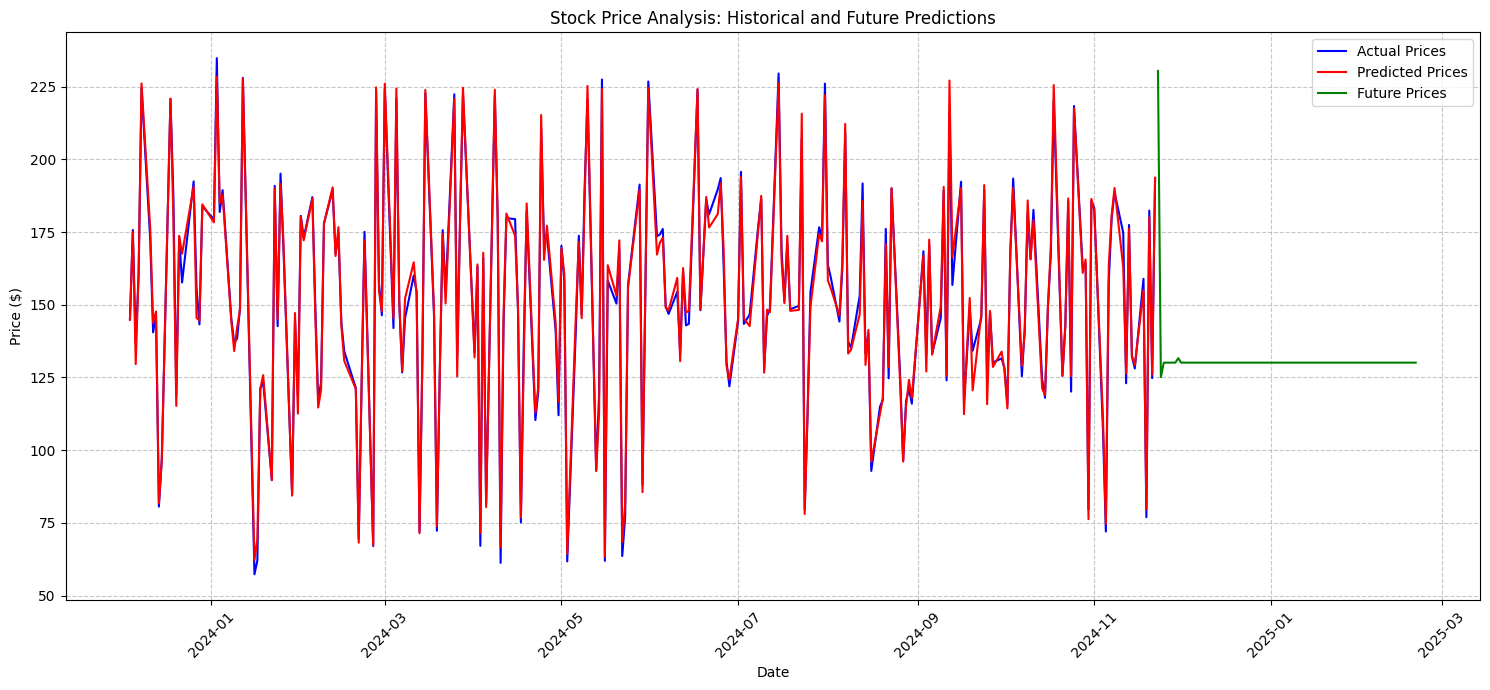

The predicted stock price for 2025-02-20 is $130.10
Sample future predictions:
Date: 2024-11-23 | Predicted Price: $230.43
Date: 2024-11-24 | Predicted Price: $125.11
Date: 2024-11-25 | Predicted Price: $130.10
Date: 2024-11-26 | Predicted Price: $130.10
Date: 2024-11-27 | Predicted Price: $130.10


In [2]:
from datetime import timedelta
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Step 1: Fetch data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Step 2: Prepare the data with lagged features
def prepare_data(data, lag=5):
    data['Date'] = data.index
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day

    # Add lagged features
    for i in range(1, lag + 1):
        data[f'Lag_{i}'] = data['Close'].shift(i)

    # Drop rows with NaN values due to lagging
    data.dropna(inplace=True)

    # Features and target
    features = data[['Year', 'Month', 'Day'] + [f'Lag_{i}' for i in range(1, lag + 1)]]
    targets = data['Close']
    return np.array(features), np.array(targets)

# Step 3: Train a kNN model
def train_knn_model(X, y, n_neighbors=5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return model, X_train, X_test, y_train, y_test, y_pred, scaler

# Step 4: Evaluate model performance
def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")

# Step 5: Predict future prices
def predict_future_prices(model, scaler, last_known_data, last_date, days=90):
    future_prices = []
    current_data = last_known_data.copy()

    for _ in range(days):
        # Predict the next price
        scaled_data = scaler.transform([current_data])
        next_price = model.predict(scaled_data)[0]  # Ensure scalar value
        future_prices.append(float(next_price))  # Convert to float

        # Update lagged features for the next prediction
        current_data = np.roll(current_data, shift=-1)
        current_data[-1] = next_price

    future_dates = [last_date + timedelta(days=i) for i in range(1, days + 1)]
    return future_dates, future_prices

# Step 6: Plot predictions
def plot_combined_results(stock_data, y_test, y_pred, future_dates, future_prices):
    plt.figure(figsize=(15, 7))
    
    # Get the dates corresponding to test data
    test_dates = stock_data.index[-len(y_test):]
    
    # Plot historical data (actual vs predicted)
    plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
    plt.plot(test_dates, y_pred, label='Predicted Prices', color='red')
    
    # Plot future predictions
    plt.plot(future_dates, future_prices, label='Future Prices', color='green')
    
    plt.legend()
    plt.title(f'Stock Price Analysis: Historical and Future Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Example usage
if __name__ == "__main__":
    ticker = 'AAPL'  # Example stock ticker
    start_date = '2020-01-01'
    end_date = '2024-11-25'

    # Fetch and prepare data
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    features, targets = prepare_data(stock_data, lag=5)

    # Train model
    model, X_train, X_test, y_train, y_test, y_pred, scaler = train_knn_model(features, targets, n_neighbors=5)
    evaluate_model(y_test, y_pred)

    # Predict future prices
    last_known_data = features[-1]  # Last feature set
    last_date = stock_data.index[-1].to_pydatetime().replace(tzinfo=None)
    future_dates, future_prices = predict_future_prices(model, scaler, last_known_data, last_date, days=90)

    # Plot results
    plot_combined_results(stock_data, y_test, y_pred, future_dates, future_prices)

    # Print future predictions
    print(f"The predicted stock price for {future_dates[-1].strftime('%Y-%m-%d')} is ${future_prices[-1]:.2f}")
    print("Sample future predictions:")
    for date, price in zip(future_dates[:5], future_prices[:5]):
        print(f"Date: {date.strftime('%Y-%m-%d')} | Predicted Price: ${price:.2f}")
